# Email Spam Detection

In [1]:
!pip install imblearn

In [3]:
import nltk
nltk.download()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import joblib
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


In [64]:
# getting csv formate data

data=pd.read_csv('messages.csv')

In [65]:
data

,subject,message,label
0,job posting - apple-iss research center,content - length : 3386 apple-iss research cen...,0
1,NaN,"lang classification grimes , joseph e . and ba...",0
2,query : letter frequencies for text identifica...,i am posting this inquiry for sergei atamas ( ...,0
3,risk,a colleague and i are researching the differin...,0
4,request book information,earlier this morning i was on the phone with a...,0
...,...,...,...
2888,love your profile - ysuolvpv,hello thanks for stopping by ! ! we have taken...,1
2889,you have been asked to join kiddin,"the list owner of : "" kiddin "" has invited you...",1
2890,anglicization of composers ' names,"judging from the return post , i must have sou...",0
2891,"re : 6 . 797 , comparative method : n - ary co...",gotcha ! there are two separate fallacies in t...,0


In [66]:
data.nunique()

subject    2613
message    2859
label         2
dtype: int64

In [67]:
data.isnull().sum()

subject    62
message     0
label       0
dtype: int64

In [68]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2893 entries, 0 to 2892
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   subject  2831 non-null   object
 1   message  2893 non-null   object
 2   label    2893 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 67.9+ KB


In [69]:
data.drop(['subject'], axis=1, inplace=True)
data

,message,label
0,content - length : 3386 apple-iss research cen...,0
1,"lang classification grimes , joseph e . and ba...",0
2,i am posting this inquiry for sergei atamas ( ...,0
3,a colleague and i are researching the differin...,0
4,earlier this morning i was on the phone with a...,0
...,...,...
2888,hello thanks for stopping by ! ! we have taken...,1
2889,"the list owner of : "" kiddin "" has invited you...",1
2890,"judging from the return post , i must have sou...",0
2891,gotcha ! there are two separate fallacies in t...,0


In [70]:

data.rename(columns={'message':'Message','label': 'Class'}, inplace=True)
data.head()

,Message,Class
0,content - length : 3386 apple-iss research cen...,0
1,"lang classification grimes , joseph e . and ba...",0
2,i am posting this inquiry for sergei atamas ( ...,0
3,a colleague and i are researching the differin...,0
4,earlier this morning i was on the phone with a...,0


In [71]:
data['Message'][0]

"content - length : 3386 apple-iss research center a us $ 10 million joint venture between apple computer inc . and the institute of systems science of the national university of singapore , located in singapore , is looking for : a senior speech scientist - - - - - - - - - - - - - - - - - - - - - - - - - the successful candidate will have research expertise in computational linguistics , including natural language processing and * * english * * and * * chinese * * statistical language modeling . knowledge of state-of - the-art corpus-based n - gram language models , cache language models , and part-of - speech language models are required . a text - to - speech project leader - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - the successful candidate will have research expertise expertise in two or more of the following areas : computational linguistics , including natural language parsing , lexical database design , and statistical language modeling ; text tokenization and

0    83.373661
1    16.626339
Name: Class, dtype: float64


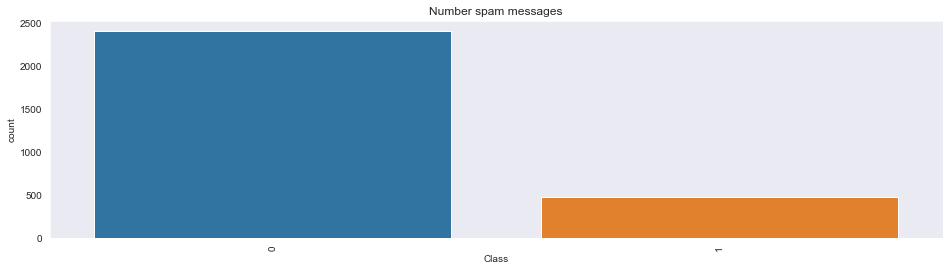

In [72]:
plt.figure(figsize=(16,4))
plt.xticks(rotation=90)
sb.set_style('dark')
print(data['Class'].value_counts()/len(data)*100)
sb.countplot(x='Class',data=data)
plt.xlabel('Class')
plt.title('Number spam messages');

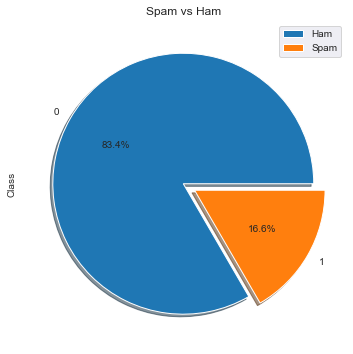

In [73]:
data["Class"].value_counts().plot(kind = 'pie',
                                  explode=[0, 0.1],
                                  figsize=(6, 6),
                                  autopct='%1.1f%%',
                                  shadow=True)
plt.title("Spam vs Ham")
plt.legend(["Ham", "Spam"])
plt.show()

In [74]:
data.describe()

,Class
count,2893.000000
mean,0.166263
std,0.372381
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [75]:
data['length'] = data.Message.apply(len)
data.head()

,Message,Class,length
0,content - length : 3386 apple-iss research cen...,0,2856
1,"lang classification grimes , joseph e . and ba...",0,1800
2,i am posting this inquiry for sergei atamas ( ...,0,1435
3,a colleague and i are researching the differin...,0,324
4,earlier this morning i was on the phone with a...,0,1046


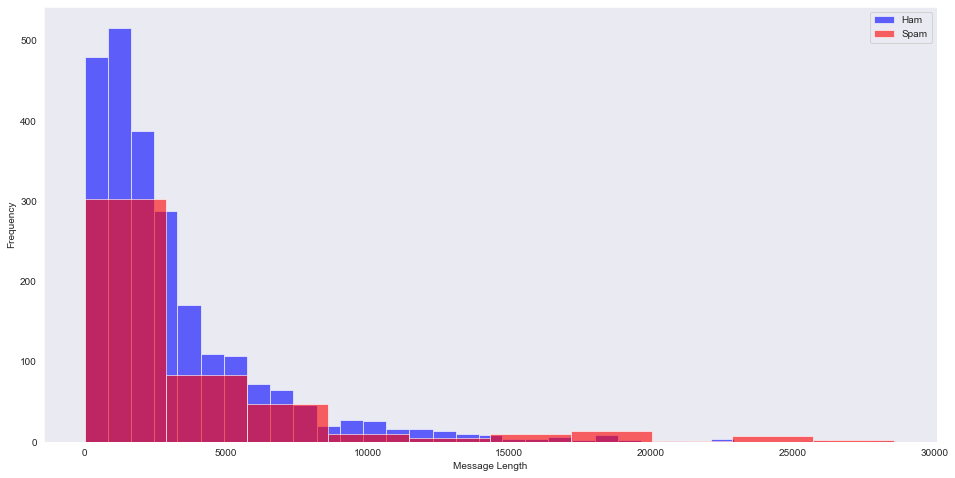

In [76]:
plt.figure(figsize=(16,8))
sb.set_style('dark')
data[data.Class == 0].length.plot(bins=35, kind='hist', color='blue', label='Ham', alpha=0.6)
data[data.Class == 1].length.plot(kind='hist', color='red', label='Spam', alpha=0.6)
plt.legend()
plt.xlabel("Message Length");

In [77]:
stop_words = stopwords.words('english')
print(stop_words[::10])


['i', "you've", 'himself', 'they', 'that', 'been', 'a', 'while', 'through', 'in', 'here', 'few', 'own', 'just', 're', 'doesn', 'ma', "shouldn't"]


In [78]:
porter = PorterStemmer()

In [79]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [80]:
def clean_text(words):
    """The function to clean text"""
    words = re.sub("[^a-zA-Z]"," ", words)
    text = words.lower().split()                   
    return " ".join(text)

data['Message_clean_text'] = data['Message'].apply(clean_text)
data.head()

,Message,Class,length,Message_clean_text
0,content - length : 3386 apple-iss research cen...,0,2856,content length apple iss research center a us ...
1,"lang classification grimes , joseph e . and ba...",0,1800,lang classification grimes joseph e and barbar...
2,i am posting this inquiry for sergei atamas ( ...,0,1435,i am posting this inquiry for sergei atamas sa...
3,a colleague and i are researching the differin...,0,324,a colleague and i are researching the differin...
4,earlier this morning i was on the phone with a...,0,1046,earlier this morning i was on the phone with a...


In [81]:
def remove_stopwords(text):
    """The function to removing stopwords"""
    text = [word.lower() for word in text.split() if word.lower() not in stop_words]
    return " ".join(text)

data['Message_remove_stopwords'] = data['Message_clean_text'].apply(remove_stopwords)
data.head()

,Message,Class,length,Message_clean_text,Message_remove_stopwords
0,content - length : 3386 apple-iss research cen...,0,2856,content length apple iss research center a us ...,content length apple iss research center us mi...
1,"lang classification grimes , joseph e . and ba...",0,1800,lang classification grimes joseph e and barbar...,lang classification grimes joseph e barbara f ...
2,i am posting this inquiry for sergei atamas ( ...,0,1435,i am posting this inquiry for sergei atamas sa...,posting inquiry sergei atamas satamas umabnet ...
3,a colleague and i are researching the differin...,0,324,a colleague and i are researching the differin...,colleague researching differing degrees risk p...
4,earlier this morning i was on the phone with a...,0,1046,earlier this morning i was on the phone with a...,earlier morning phone friend mine living south...


In [82]:
def stemmer(stem_text):
    """The function to apply stemming"""
    stem_text = [porter.stem(word) for word in stem_text.split()]
    return " ".join(stem_text)

data['Message_stemmer'] = data['Message_remove_stopwords'].apply(stemmer)
data.head()

,Message,Class,length,Message_clean_text,Message_remove_stopwords,Message_stemmer
0,content - length : 3386 apple-iss research cen...,0,2856,content length apple iss research center a us ...,content length apple iss research center us mi...,content length appl iss research center us mil...
1,"lang classification grimes , joseph e . and ba...",0,1800,lang classification grimes joseph e and barbar...,lang classification grimes joseph e barbara f ...,lang classif grime joseph e barbara f grime et...
2,i am posting this inquiry for sergei atamas ( ...,0,1435,i am posting this inquiry for sergei atamas sa...,posting inquiry sergei atamas satamas umabnet ...,post inquiri sergei atama satama umabnet ab um...
3,a colleague and i are researching the differin...,0,324,a colleague and i are researching the differin...,colleague researching differing degrees risk p...,colleagu research differ degre risk perceiv ho...
4,earlier this morning i was on the phone with a...,0,1046,earlier this morning i was on the phone with a...,earlier morning phone friend mine living south...,earlier morn phone friend mine live south amer...


In [83]:
data['message'] = data['Message_stemmer']

In [90]:
X = data['message']
y = data['Class']

In [91]:
vect = CountVectorizer(min_df=5, ngram_range=(1,2)).fit(X)

X_vec = vect.transform(X)

len(vect.get_feature_names())

27479

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.2, random_state = 0)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2314, 27479)
(579, 27479)
(2314,)
(579,)


In [93]:

smote = SMOTE()
X_train_sm,y_train_sm = smote.fit_resample(X_train,y_train)

In [94]:

print(X_train_sm.shape)
print(y_train_sm.shape)

(3876, 27479)
(3876,)


In [95]:
model_lr = Pipeline([('tfidf', TfidfTransformer()),
                   ('model',LogisticRegression()),
                   ])

model_lr.fit(X_train_sm,y_train_sm)

ytest = np.array(y_test)
pred_y = model_lr.predict(X_test)

In [96]:
print('accuracy %s' % accuracy_score(pred_y, y_test))
print(classification_report(ytest, pred_y))

accuracy 0.998272884283247
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       474
           1       0.99      1.00      1.00       105

    accuracy                           1.00       579
   macro avg       1.00      1.00      1.00       579
weighted avg       1.00      1.00      1.00       579



In [97]:
model_nb = Pipeline([('tfidf', TfidfTransformer()),
                   ('model',MultinomialNB()),
                   ])

model_nb.fit(X_train_sm,y_train_sm)

ytest = np.array(y_test)
pred = model_nb.predict(X_test)
print('accuracy %s' % accuracy_score(pred, y_test))
print(classification_report(ytest, pred))

accuracy 0.9965457685664939
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       474
           1       0.99      0.99      0.99       105

    accuracy                           1.00       579
   macro avg       0.99      0.99      0.99       579
weighted avg       1.00      1.00      1.00       579



In [98]:
model_rf = Pipeline([('tfidf', TfidfTransformer()),
                   ('model',RandomForestClassifier(n_estimators=50)),
                   ])

model_rf.fit(X_train_sm,y_train_sm)

ytest = np.array(y_test)
preds = model_rf.predict(X_test)
print('accuracy %s' % accuracy_score(preds, y_test))
print(classification_report(ytest, preds))

accuracy 0.9861830742659758
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       474
           1       0.95      0.97      0.96       105

    accuracy                           0.99       579
   macro avg       0.97      0.98      0.98       579
weighted avg       0.99      0.99      0.99       579



In [99]:

model_gb = Pipeline([('tfidf', TfidfTransformer()),
                    ('model', GradientBoostingClassifier(random_state=100, n_estimators=150,min_samples_split=100, max_depth=6)),
                    ])

model_gb.fit(X_train_sm,y_train_sm)

ytest = np.array(y_test)
y_pred = model_gb.predict(X_test)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(ytest, y_pred))

accuracy 0.9602763385146805
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       474
           1       0.83      0.98      0.90       105

    accuracy                           0.96       579
   macro avg       0.91      0.97      0.94       579
weighted avg       0.97      0.96      0.96       579



In [101]:
model_svc = Pipeline([('tfidf', TfidfTransformer()),
                     ('model',LinearSVC()),
                     ])

model_svc.fit(X_train_sm,y_train_sm)

ytest = np.array(y_test)
predict = model_svc.predict(X_test)
print('accuracy %s' % accuracy_score(predict, y_test))
print(classification_report(ytest, predict))

accuracy 0.9930915371329879
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       474
           1       0.96      1.00      0.98       105

    accuracy                           0.99       579
   macro avg       0.98      1.00      0.99       579
weighted avg       0.99      0.99      0.99       579



In [103]:
model_sg = Pipeline([('tfidf', TfidfTransformer()),
                     ('model',SGDClassifier()),
                     ])

model_sg.fit(X_train_sm,y_train_sm)

ytest = np.array(y_test)
predicted = model_sg.predict(X_test)
print('accuracy %s' % accuracy_score(predicted, y_test))
print(classification_report(ytest, predicted))

accuracy 0.9844559585492227
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       474
           1       0.92      1.00      0.96       105

    accuracy                           0.98       579
   macro avg       0.96      0.99      0.97       579
weighted avg       0.99      0.98      0.98       579



In [104]:
log_acc = accuracy_score(pred_y, y_test)
nb_acc = accuracy_score(pred, y_test)
rf_acc = accuracy_score(preds, y_test)
gb_acc = accuracy_score(y_pred, y_test)
svm_acc = accuracy_score(predict, y_test)
sg_acc = accuracy_score(predicted, y_test)


In [105]:
models = pd.DataFrame({
                      'Model': ['Logistic Regression', 'Naive Bayes', 'Random Forest', 'Gradient Boosting', 'SVM', 'SGD'],
                      'Score': [log_acc, nb_acc, rf_acc, gb_acc, svm_acc, sg_acc]})
models.sort_values(by='Score', ascending=False)

,Model,Score
0,Logistic Regression,0.998273
1,Naive Bayes,0.996546
4,SVM,0.993092
2,Random Forest,0.986183
5,SGD,0.984456
3,Gradient Boosting,0.960276


In [ ]:
### Conclusion
This project was aimed to text classification to determined whether the messages is spam or not.
We started with the dcleaning and text mining, which cover change text into tokens, remove punctuation, stop words and normalization them by stemming. Following we used bag of words model to convert the text into numerical feature vectors. Finally we started training six different classification models and we got the best accuracy of 0.97 for Naive Bayes method.